<a href="https://colab.research.google.com/github/elmedianikhadija/PFE-WITH-SIR/blob/main/Sliding%20SIR%20Model%20for%20Rt%20Estimation%20during%20COVID%20Pandemic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://soshnikov.com/science/sliding-sir-model-for-rt-estimation/

In [1]:
import sys
!{sys.executable} -m pip install --user --quiet pandas>=1.0.3 matplotlib scipy numpy


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

In [3]:
infected_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
deaths_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
countries_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"

In [4]:
countries = pd.read_csv(countries_dataset_url)
infected_original = pd.read_csv(infected_dataset_url)
recovered_original = pd.read_csv(recovered_dataset_url)
deaths_original = pd.read_csv(deaths_dataset_url)
countries.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.0,NaN,NaN,NaN,Afghanistan,33.93911,67.709953,Afghanistan,38928341.0
1,8,AL,ALB,8.0,NaN,NaN,NaN,Albania,41.15330,20.168300,Albania,2877800.0
2,10,AQ,ATA,10.0,NaN,NaN,NaN,Antarctica,-71.94990,23.347000,Antarctica,NaN
3,12,DZ,DZA,12.0,NaN,NaN,NaN,Algeria,28.03390,1.659600,Algeria,43851043.0
4,20,AD,AND,20.0,NaN,NaN,NaN,Andorra,42.50630,1.521800,Andorra,77265.0


In [5]:
population = countries[countries['Province_State'].isnull()][['Country_Region','Population']].rename(columns={'Country_Region' : 'Country/Region'}).set_index('Country/Region')
infected = infected_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
deaths = deaths_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
recovered = recovered_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
infected.head()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/17/22,4/18/22,4/19/22,4/20/22,4/21/22,4/22/22,4/23/22,4/24/22,4/25/22,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,...,178418,178457,178513,178574,178611,178638,178648,178689,178745,38928341.0
Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,...,274504,274520,274535,274606,274606,274737,274791,274828,274828,2877800.0
Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,...,265739,265741,265746,265746,265754,265761,265761,265767,265771,43851043.0
Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,...,40709,40709,40709,41013,41013,41013,41013,41013,41013,77265.0
Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,...,99194,99194,99287,99287,99287,99287,99287,99287,99287,32866268.0


In [6]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Compute SIR model starting from given numbers of infected/removed ppl
def sir_model(infected,removed,N,beta,gamma,ndays):
    t = np.linspace(0,ndays,ndays)
    y0 = N-infected-removed,infected,removed
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    return ret.T # S,I,R

In [7]:
# Модель по заданному вектору заболевших V и удалённых R
def model(V,R,N,beta,gamma):
    S,I,R = sir_model(V[0],R[0],N,beta,gamma,len(V))
    dV = np.diff(V)
    dI = np.diff(I+R)
    return np.linalg.norm(dV-dI)

# Fix the gamma parameter
the_gamma = 1/30

# Подобрать параметры модели по векторам V и R
def fit(V,R,N):
    # res = minimize(lambda x:model(V,R,N,x[0],x[1]),x0=[0.5,1/20],method='powell')
    # return res.x[0],res.x[1]
    res = minimize(lambda x:model(V,R,N,x,the_gamma),x0=0.5,method='powell')
    return res.x,the_gamma

In [8]:
def make_frame(country_name,smooth_window=3):
    f = pd.DataFrame([infected.loc[country_name],recovered.loc[country_name],deaths.loc[country_name]]).T
    population = f.iloc[-1,0]
    f = f.iloc[2:-1].reset_index()
    f.columns = ['Date','Infected','Recovered','Deaths']
    f['Removed'] = f['Recovered']+f['Deaths']
    f["Date"] = pd.to_datetime(f["Date"],format="%m/%d/%y")
    for x in ['Infected','Recovered','Deaths','Removed']:
        f[x+"_Av"] = f[x].rolling(window=smooth_window).mean()
    return population, f

def get_start_index(df):
    return df[df['Infected_Av']>1000].index[0]

In [9]:
def compute_params(df,population, start_index, ndays=8):
    for i in range(start_index,len(df)-ndays):
        V = df['Infected_Av'][i:i+ndays].to_numpy()
        R = df['Removed_Av'][i:i+ndays].to_numpy()
        beta,gamma = fit(V,R,population)
        df.loc[i,'Beta'] = beta
        df.loc[i,'Gamma'] = gamma

In [10]:
def analyze(country_name,truncate_frame=True):
    population, df = make_frame(country_name)
    n = get_start_index(df)
    compute_params(df,population,n)
    df['Rt'] = df['Beta'] / df['Gamma']
    return population, df.iloc[n:] if truncate_frame else df

pop, df = analyze('Russia')

In [11]:
df.head()

,Date,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt
66,2020-03-28,1264.0,49.0,4.0,53.0,1046.666667,44.000000,3.666667,47.666667,0.187094,0.033333,5.612825
67,2020-03-29,1534.0,64.0,8.0,72.0,1278.000000,52.666667,5.333333,58.000000,0.175746,0.033333,5.272391
68,2020-03-30,1836.0,66.0,9.0,75.0,1544.666667,59.666667,7.000000,66.666667,0.168310,0.033333,5.049302
69,2020-03-31,2337.0,121.0,17.0,138.0,1902.333333,83.666667,11.333333,95.000000,0.162722,0.033333,4.881660
70,2020-04-01,2777.0,190.0,24.0,214.0,2316.666667,125.666667,16.666667,142.333333,0.158950,0.033333,4.768512


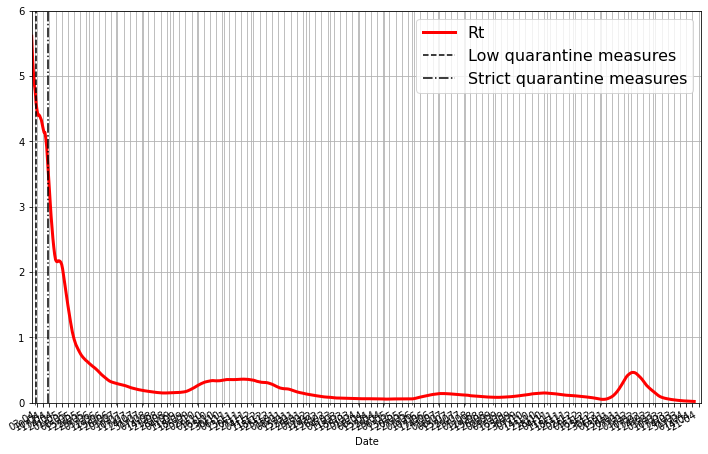

In [12]:
import matplotlib.dates as mdates
ax = df.plot('Date','Rt',linewidth=3,color='red',grid=True,ylim=(0,6),figsize=(12,8))
ax.axvline('2020-04-02', color='k', linestyle='--',label='Low quarantine measures')
ax.axvline('2020-04-15', color='k', linestyle='-.',label='Strict quarantine measures')
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gcf().autofmt_xdate()
plt.legend(fontsize=16)

Population = 145934460.0, Infection start date (>100) = 2020-03-28


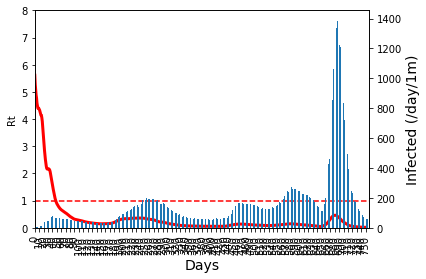

In [13]:
def plot(population,df,ax=None):
    n = 0 # get_start_index(df)
    start_date = df.iloc[n,0]
    if ax is None:
        print("Population = {}, Infection start date (>100) = {}".format(population,start_date.date()))
    df['Days'] = df['Date'].apply(lambda x : (x-start_date).days)
    df['PI'] = df['Infected'] / population * 100
    df['Delta_Infected_Gr'] = (df['Infected'].diff()).clip(lower=0) / population * 1000000
    ax = ax or plt.gca()
    ax = df.plot('Days','Rt',ax=ax,legend=False,linewidth=3,color='red')
    ax.axhline(y = 1,linestyle='--', color='red')
    ax.set_ylim(0,8)
    ax.set_ylabel('Rt')
    df.plot(x='Days',y='Delta_Infected_Gr',secondary_y=True,kind='bar',ax=ax,legend=False)#,xticks=df['Days'][::10])
    ax.set_xlabel('Days',fontsize=14)
    ax.set_xticks(df['Days'][::10])
    ax.set_xticklabels(df['Days'][::10])
    ax.right_ax.set_ylabel('Infected (/day/1m)',fontsize=14)

plot(pop,df)

In [15]:
countries = [
    ['Spain','Italy', 'France', 'Germany'],
    ['Brazil', 'United Kingdom', 'US', 'Russia'],
    ['Sweden', 'Norway', 'Finland', 'Denmark'],        
    ['China', 'Japan', 'Korea, South', 'India']]

# Compute all countries
country_data = {}
for x in sum(countries,[]):
    print("Computing data for {}".format(x))
    country_data[x] = analyze(x)

Computing data for Spain
Computing data for Italy
Computing data for France
Computing data for Germany
Computing data for Brazil
Computing data for United Kingdom
Computing data for US
Computing data for Russia
Computing data for Sweden
Computing data for Norway
Computing data for Finland
Computing data for Denmark
Computing data for China
Computing data for Japan
Computing data for Korea, South
Computing data for India


In [16]:
r0s = pd.DataFrame([ (c,k[1].iloc[0]['Rt']) for c,k in country_data.items() ],columns=['Country','R0'])
r0s

,Country,R0
0,Spain,8.269101
1,Italy,6.389969
2,France,6.173621
3,Germany,6.864733
4,Brazil,4.786171
5,United Kingdom,5.726646
6,US,8.786997
7,Russia,5.612825
8,Sweden,2.631261
9,Norway,2.816184


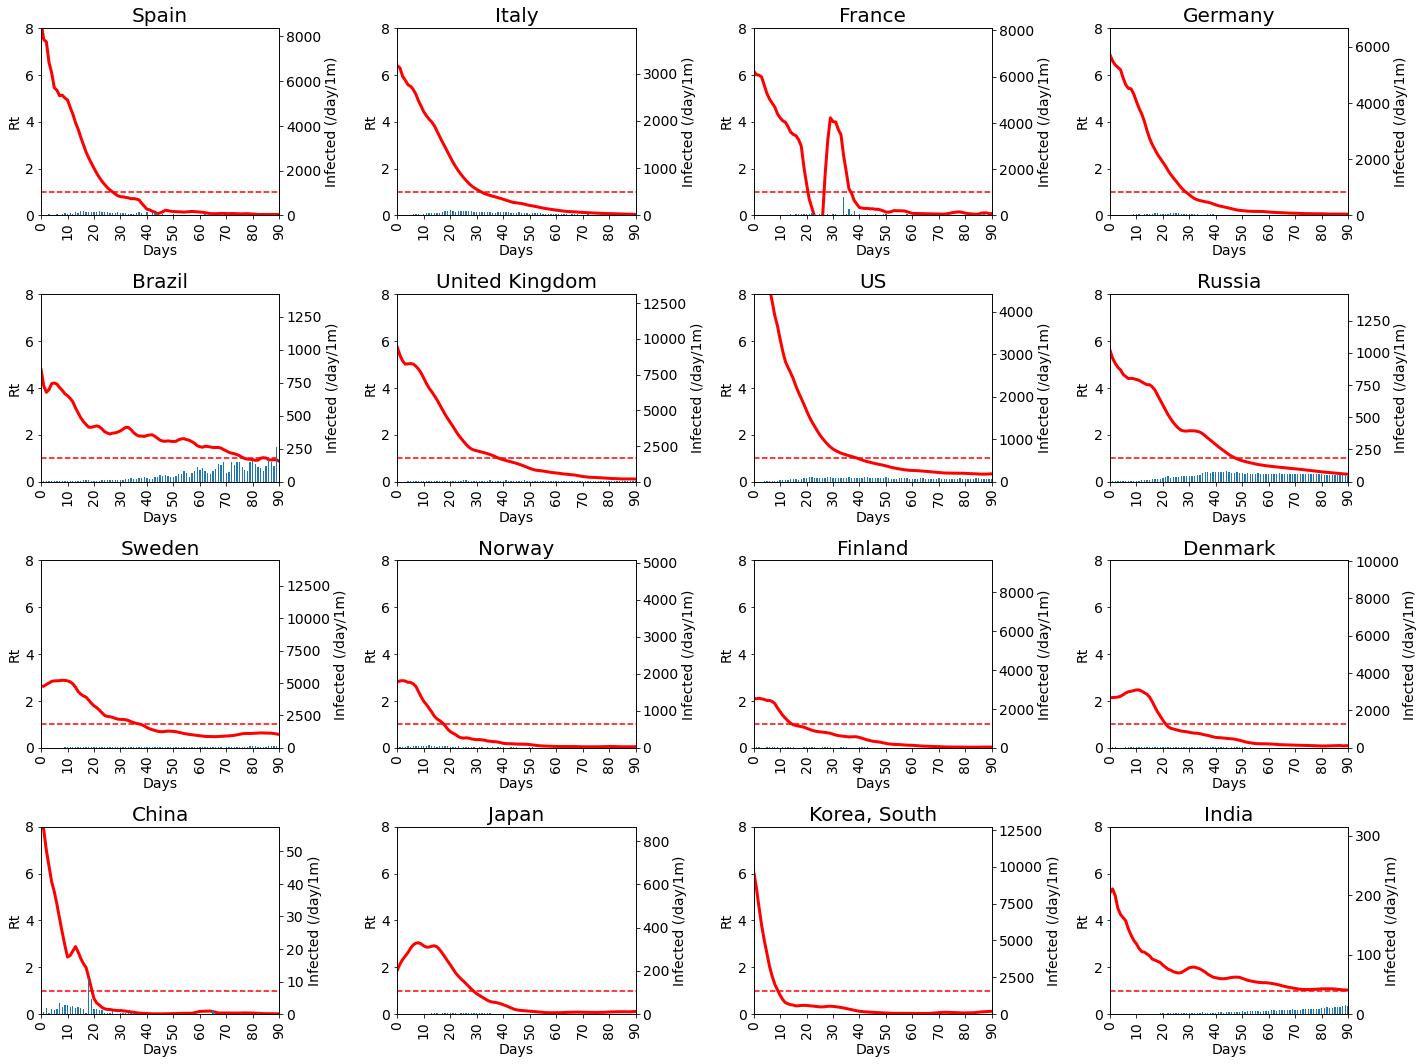

In [17]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('font',size=14)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_data[c]
        plot(pop,df,ax=ax[i,j])
        ax[i,j].set_xlim(0,90)
        ax[i,j].set_title(c,fontsize=20)
        ax[i,j].axes.xaxis.set_visible(True)
fig.tight_layout()
plt.show()

In [18]:
rtdf = [
    cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items()]

In [19]:
from functools import reduce
rtdf = reduce(lambda df,f : df.join(f), rtdf)

In [20]:
rtdf

,Spain,Italy,France,Germany,Brazil,United Kingdom,US,Russia,Sweden,Norway,Finland,Denmark,China,Japan,"Korea, South",India
Days,,,,,,,,,,,,,,,,
0,8.269101,6.389969,6.173621,6.864733,4.786171,5.726646,8.786997,5.612825,2.631261,2.816184,2.125027,2.140018,8.342098,1.882494,6.108928,5.172934
1,7.504461,6.292825,6.007047,6.594144,4.094580,5.385959,9.005944,5.272391,2.630519,2.859783,2.090820,2.147184,7.874408,2.140419,5.427024,5.344840
2,7.412181,5.933487,5.989156,6.424906,3.813978,5.150827,8.986603,5.049302,2.703973,2.868723,2.117438,2.150634,6.986360,2.326831,4.588126,5.055862
3,6.529068,5.767845,5.912089,6.324705,3.929132,5.016543,9.154673,4.881660,2.767399,2.851510,2.094139,2.165202,6.316354,2.478994,3.799116,4.515660
4,6.089457,5.581471,5.558392,6.222227,4.182758,5.025610,9.089509,4.768512,2.836120,2.797136,2.067537,2.203698,5.641770,2.622973,3.158328,4.253861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,NaN,0.147193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.027563,NaN,0.441415,NaN
773,NaN,0.143518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975853,NaN,0.409883,NaN
774,NaN,0.140890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926382,NaN,0.385453,NaN


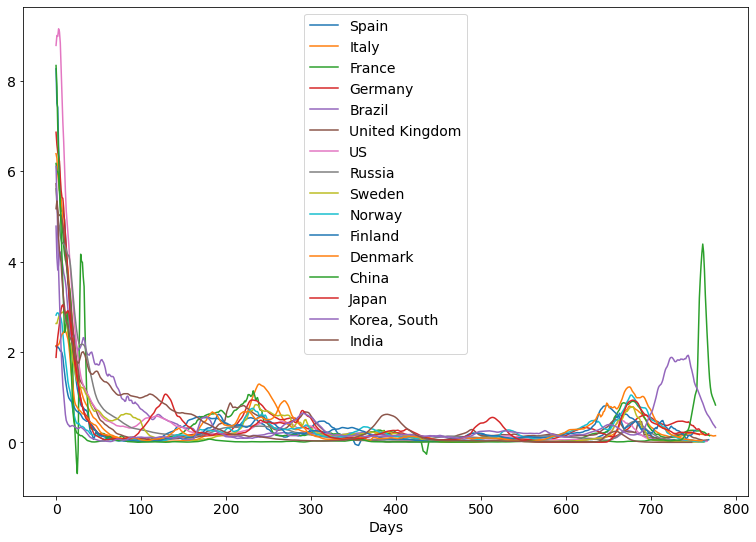

In [21]:
rtdf.plot(figsize=(13,9))

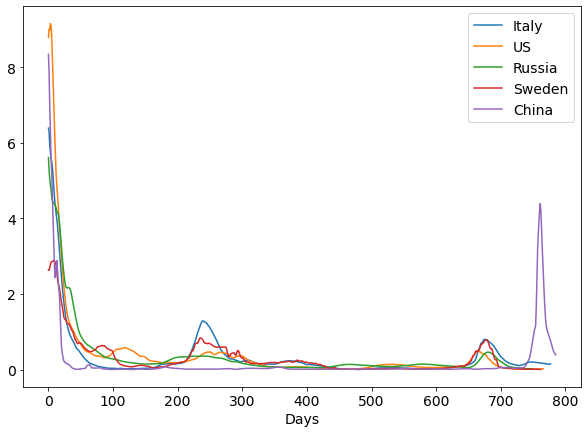

In [22]:
def plot_countries(l):
    rtdf = [cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items() if c in l]
    rtdf = reduce(lambda df,f : df.join(f), rtdf)
    rtdf.plot(figsize=(10,7))

plot_countries(['Russia','US','Italy','China','Sweden'])

In [23]:
apple_mobility_dataset_url = "https://covid19-static.cdn-apple.com/covid19-mobility-data/2010HotfixDev18/v3/en-us/applemobilitytrends-2020-06-14.csv"

In [24]:
apple_mobility = pd.read_csv(apple_mobility_dataset_url)
apple_mobility.head()

HTTPError: ignored

In [ ]:
apple_mobility['cou'] = np.where(np.logical_or(apple_mobility['geo_type']=='city',apple_mobility['geo_type']=='sub-region'),apple_mobility['country'],apple_mobility['region'])
apple = apple_mobility[apple_mobility['geo_type']!='county'].groupby('cou').mean().reset_index().set_index('cou')
apple.head()

In [ ]:
country_mapping = { 'US' : 'United States', 'China' : None, 'Korea, South' : 'Republic of Korea' }

In [ ]:
def add_apple_index(df,country_name):
    country_name = country_mapping.get(country_name,country_name)
    if country_name is None:
        df['AppleIndex'] = 0
        df['AppleIndexAv'] = 0
        return df
    start_date = df.iloc[0]['Date']
    tdf = apple.loc[country_name].T.reset_index().rename(columns={'index':'Date', country_name : 'AppleIndex'})
    tdf["Date"] = pd.to_datetime(tdf["Date"],format="%Y-%m-%d")
    tdf["AppleIndexAv"] = tdf["AppleIndex"].rolling(window=7).mean()
    tdf = tdf[tdf['Date']>=start_date].set_index('Date')
    return df.join(tdf,on='Date')

In [ ]:
country_datax = { k : (d[0],add_apple_index(d[1],k)) for k,d in country_data.items() }
country_datax['Russia'][1].head()

In [ ]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        axe=df.plot('Days','Rt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 90)
        axe.set_ylim(0, 10)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=False,xticks=df['Days'][::10], linewidth=3,)
        ax[i,j].right_ax.set_ylim(0, 150)
fig.tight_layout()
plt.show()

In [ ]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["dRt/dt"] = df["Rt"].diff().rolling(window=7).mean()
        axe=df.plot('Days','dRt/dt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 90)
        axe.set_ylim(-0.6, 0.1)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=False,xticks=df['Days'][::10], linewidth=3,)
        ax[i,j].right_ax.set_ylim(0, 150)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

In [ ]:
mx = max([len(x) for x in countries])
my = len(countries)
fig,ax = plt.subplots(my,mx,figsize=(20,15))
fig.tight_layout()
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["RtP"] = df["Rt"].diff()
        df["RtP_7"] = (df["RtP"]).rolling(window=7).mean()
        axe2=df.plot('Days','RtP_7',ax=ax[i,j])
        axe2.set_ylim(-0.6, 0.15)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe2,legend=False,xticks=df['Days'][::10])
        ax[i,j].right_ax.set_ylim(0, 150)
        ax[i,j].set_title(c)

plt.show()